In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import numpy as np
import os

# Method 2

/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_1228/454654463.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))


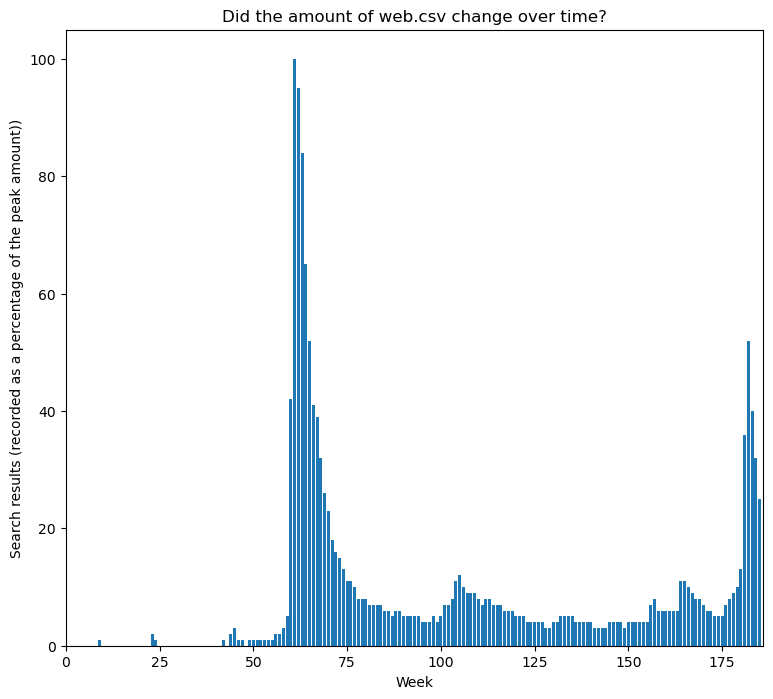

In [2]:
def searchresultbarchartplotter(file):
    """Plots a barchart of the frequency of seach results for the type of internet search."""
    data = pd.read_csv(file)
    
    data2 = data.replace('<1',0).values[1:]
    data3=[]
    for i in data2:
        data3.append(int(i))
    values =np.array(data3) #count_data
    weeks = len(values) #n_count_data in the book
    
    plt.rcParams['figure.figsize'] = [9, 8]
    plt.bar(np.arange(weeks), np.array(values))
    plt.xlabel("Week")
    plt.ylabel("Search results (recorded as a percentage of the peak amount))")
    plt.title(f"Did the amount of {file} change over time?")
    plt.xlim(0, weeks);
    plt.show()
for i in ['web.csv']:
    searchresultbarchartplotter(i)

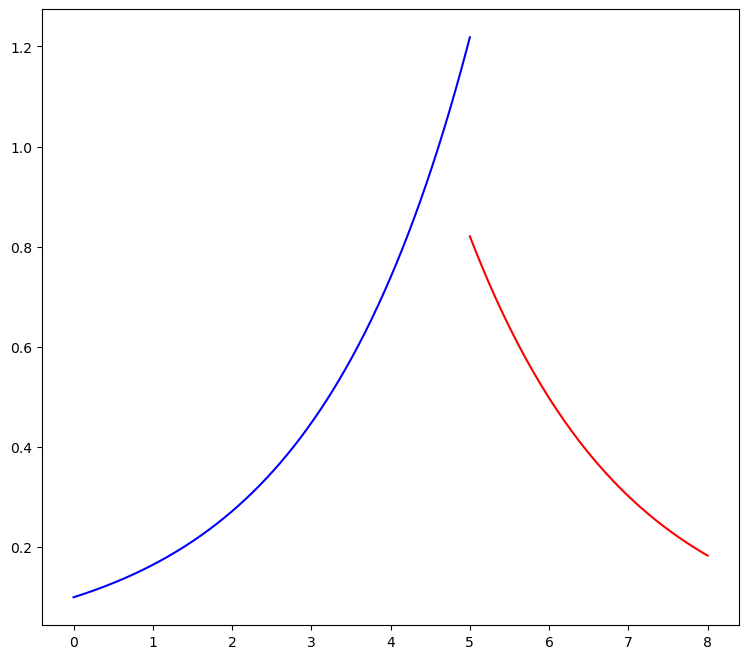

In [3]:
def my_exponential(x,a,b,c,d):
    power = (b*x) + c
    return (a*np.exp(power)) + d
x=np.linspace(5,8,1000)
x2=np.linspace(0,5,1000)
plt.plot(x2,my_exponential(x2,0.1,0.5,0,0), 'b')
plt.plot(x,my_exponential(x,10,-0.5,0,0), 'r')

/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_1228/874654566.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(float(i))
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [a1]
>Metropolis: [a2]
>Metropolis: [a3]
>Metropolis: [a4]
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [tau_2]
>Metropolis: [tau_3]
>Metropolis: [tau]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 89 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The MSE is: 58.25894838524867


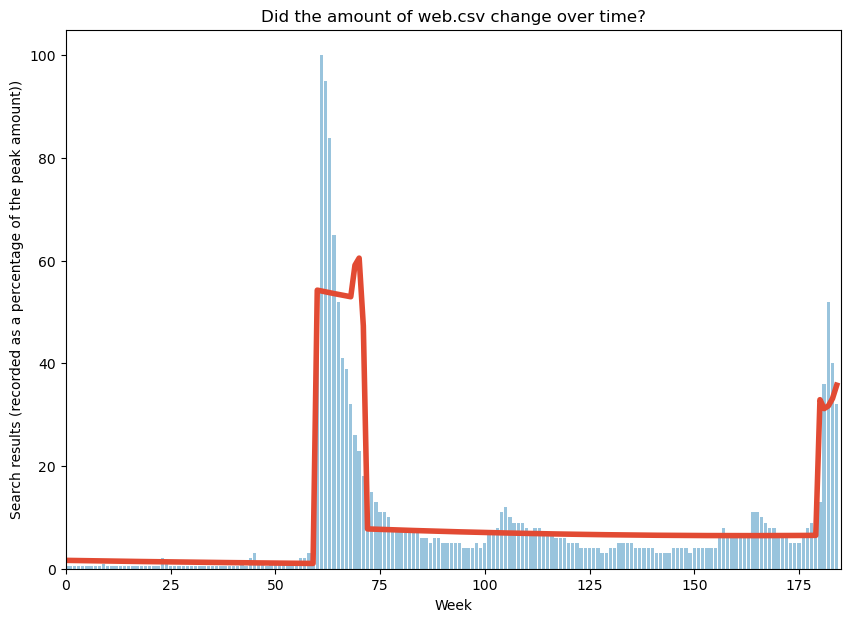

In [21]:
os.chdir('/Users/elliotbarlow/Desktop/dissertation/Methodology')
def exponentialdecaymodel(file, startweek = 0, endweek = -1):
    if file is None:
        data2 = [50]*100 +[25]*100 + [75]*100 +[100]*100
        data2 = [50]*100
    else:
        data = pd.read_csv(file)
    
        data2 = data.replace('<1',0.5).values[1:]
        #data2 = data2.replace(0,0.5).values[1:]
    data3 = []

    for i in data2[startweek : endweek]:
        data3.append(float(i))
    values = np.array(data3) #count_data in the book
    weeks = len(values) #n_count_data in the book
    alpha = 1.0 / weeks
    
    with pm.Model() as model:
        a1 = pm.Exponential("a1", 2/np.max(values[0:int(len(values)/4)]) )#, sigma = np.std(values))
        a2 = pm.Exponential("a2", 2/np.max(values[int(len(values)/4):int(len(values)/2)]) )#, sigma = np.std(values))
        a3 = pm.Exponential("a3", 2/np.max(values[int(len(values)/2):int(3*len(values)/4)]) )#, sigma = np.std(values))
        a4 = pm.Exponential("a4", 2/np.max(values[int(3*len(values)/4):]) )#, sigma = np.std(values))
        
        #Period one: 0-Tau: lambda_1
        lambda_1 = pm.Normal("lambda_1", mu = 0, sigma = 0.5)
        #Period two: Tau-Tau_2: lambda_2
        lambda_2 = pm.Normal("lambda_2", mu = 0, sigma = 0.5)
        #Period three: Tau_2-Tau_3: lambda_3
        lambda_3 = pm.Normal("lambda_3", mu = 0, sigma = 0.5)
        #Period four: Tau_3-End: lambda_4
        lambda_4 = pm.Normal("lambda_4", mu = 0, sigma = 0.5)
        
        tau_2 = pm.Uniform("tau_2", lower = 0, upper = weeks)
        tau_3 = pm.Uniform("tau_3", lower = tau_2, upper = weeks)
        tau = pm.Uniform("tau", lower = 0, upper = tau_2) 
        
        weekssubtrcattau = pm.Deterministic('weekssubtrcattau', weeks - tau)
        weekssubtrcattau2 = pm.Deterministic('weekssubtrcattau2', weeks - tau_2)
        weekssubtrcattau3 = pm.Deterministic('weekssubtrcattau3', weeks - tau_3)

        
        idx = np.arange(weeks) # Index
        lambda_ = pm.math.switch(idx < tau, lambda_1,
                                 pm.math.switch(idx < tau_2, lambda_2, 
                                                pm.math.switch(idx < tau_3, lambda_3, lambda_4)))
        
        amplitude_ = pm.math.switch(idx < tau, a1,
                                 pm.math.switch(idx < tau_2, a2, 
                                                pm.math.switch(idx < tau_3, a3, a4)))
        weeks_ = pm.math.switch(idx < tau, weeks,
                                 pm.math.switch(idx < tau_2, weekssubtrcattau , 
                                                pm.math.switch(idx < tau_3, weekssubtrcattau2, weekssubtrcattau3)))
        
        rate = my_exponential(weeks_, amplitude_, lambda_, 0, 0) 
        observation = pm.Poisson("obs", rate, observed=values)
        
        step = pm.Metropolis()
        trace = pm.sample(50000, tune = 10000, step = step, return_inferencedata = False)
        
    a1samples = trace['a1']
    a2samples = trace['a2']
    a3samples = trace['a3']
    a4samples = trace['a4']
    
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    lambda_3_samples = trace['lambda_3']
    lambda_4_samples = trace['lambda_4']
    
    tau_samples = trace['tau']
    tau_2_samples = trace['tau_2']
    tau_3_samples = trace['tau_3']

    expected_texts_per_day = np.zeros(weeks)
    N = tau_samples.shape[0]
    for day in range(0, weeks):
        ix_1 = day < tau_samples
        
        ix2_upperbound = (day < tau_2_samples)
        ix2_lowerbound = (day > tau_samples)
        ix_2 = np.logical_and(ix2_upperbound, ix2_lowerbound)

        ix3_upperbound = (day < tau_3_samples)
        ix3_lowerbound = (day > tau_2_samples)
        ix_3 = np.logical_and(ix3_upperbound, ix3_lowerbound)

        ix_4 = day > tau_3_samples

        mean1 = 0
        mean2 = 0
        mean3 = 0
        mean4 = 0
        if np.sum(ix_1)>0:
            mean1 = np.mean(my_exponential(day, (a1samples[ix_1]),(lambda_1_samples[ix_1]),0,0) )
        if np.sum(ix_2)>0:
            mean2 = np.mean(my_exponential((day -  tau_samples)[ix_2], (a2samples[ix_2]),(lambda_2_samples[ix_2]),0,0) )
        if np.sum(ix_3)>0:
            mean3 = np.mean(my_exponential((day - tau_2_samples)[ix_3], (a3samples[ix_3]),(lambda_3_samples[ix_3]),0,0) )
        if np.sum(ix_4)>0:
            mean4 = np.mean(my_exponential((day - tau_3_samples)[ix_4], (a4samples[ix_4]),(lambda_4_samples[ix_4]),0,0) )
        expected_texts_per_day[day] = (mean1 + mean2 + mean3 + mean4)
    
    plt.rcParams['figure.figsize'] = [10, 7]
    plt.plot(range(weeks), expected_texts_per_day, color="#E24A33", lw=4,
             label = f"Expected number of search results received according to an exponential decay based model")
    
    if endweek == -1:
        plt.xlim(startweek, weeks)
    else:
        plt.xlim(startweek, endweek)
    plt.bar(np.arange(weeks), values, color="#348ABD", alpha=0.5,
            label="Observed searches per day")
    name = file
    plt.xlabel("Week")
    plt.ylabel("Search results (recorded as a percentage of the peak amount))")
    plt.title(f"Did the amount of {file} change over time?")
    
    # mplot=10000
    # for j in range(mplot):
    #     i = int((N/mplot)*j)
    #     expected_texts_per_day_i = np.zeros(weeks)
    #     a1samples = trace['a1'][i:i+1]
    #     a2samples = trace['a2'][i:i+1]
    #     a3samples = trace['a3'][i:i+1]
    #     a4samples = trace['a4'][i:i+1]
        
    #     lambda_1_samples = trace['lambda_1'][i:i+1]
    #     lambda_2_samples = trace['lambda_2'][i:i+1]
    #     lambda_3_samples = trace['lambda_3'][i:i+1]
    #     lambda_4_samples = trace['lambda_4'][i:i+1]
        
    #     tau_samples = trace['tau'][i:i+1]
    #     tau_2_samples = trace['tau_2'][i:i+1]
    #     tau_3_samples = trace['tau_3'][i:i+1]
    #     for day in range(0, weeks):
    #         ix_1 = day < tau_samples
            
    #         ix2_upperbound = (day < tau_2_samples)
    #         ix2_lowerbound = (day > tau_samples)
    #         ix_2 = np.logical_and(ix2_upperbound, ix2_lowerbound)
    
    #         ix3_upperbound = (day < tau_3_samples)
    #         ix3_lowerbound = (day > tau_2_samples)
    #         ix_3 = np.logical_and(ix3_upperbound, ix3_lowerbound)
    
    #         ix_4 = day > tau_3_samples
    
    #         mean1 = 0
    #         mean2 = 0
    #         mean3 = 0
    #         mean4 = 0
    #         if np.sum(ix_1)>0:
    #             mean1 = np.mean(my_exponential(day, (a1samples[ix_1]),(lambda_1_samples[ix_1]),0,0) )
    #         if np.sum(ix_2)>0:
    #             mean2 = np.mean(my_exponential((day -  tau_samples)[ix_2], (a2samples[ix_2]),(lambda_2_samples[ix_2]),0,0) )
    #         if np.sum(ix_3)>0:
    #             mean3 = np.mean(my_exponential((day - tau_2_samples)[ix_3], (a3samples[ix_3]),(lambda_3_samples[ix_3]),0,0) )
    #         if np.sum(ix_4)>0:
    #             mean4 = np.mean(my_exponential((day - tau_3_samples)[ix_4], (a4samples[ix_4]),(lambda_4_samples[ix_4]),0,0) )
    #         expected_texts_per_day_i[day] = (mean1 + mean2 + mean3 + mean4)
            
    #     plt.plot(range(weeks), expected_texts_per_day_i, "g--", lw=0.1, alpha=0.045)
        
    # plt.legend(loc="upper left")
    # plt.ylim(0,100)
    # plt.show()

    differences = ( np.array(expected_texts_per_day) - np.array(values) )**2
    MSE = ( sum(differences)/len(values) )
    print('The MSE is:', MSE)
       
    #return trace, expected_texts_per_day
exponentialdecaymodel('web.csv', 0,)

# Compiling the results

### You don't need to run the following codes as it will take too long and the results are already provided

all_game_model_stats = []
failedlist = []
for year in [2022, 2023]: 
    os.chdir(f'/Users/elliotbarlow/Desktop/dissertation/data/{year}')
    directlist = [d.name for d in os.scandir() if d.is_dir() and d != '.DS_Store']
    for game in directlist:
        os.chdir(f'/Users/elliotbarlow/Desktop/dissertation/data/{year}/')
        print(game)
        os.chdir(f'/Users/elliotbarlow/Desktop/dissertation/data/{year}/{game}')
        
        potentialfilenames = os.listdir()
        filenames = []
        for potentialfile in potentialfilenames:
            if potentialfile in ['news searches.csv', 'youtube searches.csv', 'web searches.csv']:
                filenames.append(potentialfile)         
            
        print(filenames)
        game_model_stats_stats = []
        for file in filenames:
            print(file)
            try:
                data = pd.read_csv(file)
                data2 = data.replace('<1',0.5).values[1:]
                data3 = []
                for i in data2[0:-1]:
                    data3.append(float(i))
                    
                values = np.array(data3) #count_data in the book
                weeks = len(values) #n_count_data in the book
                alpha = 1.0 / weeks
                
                with pm.Model() as model:
                    a1 = pm.Exponential("a1", 2/np.max(values[0:int(len(values)/4)]) )#, sigma = np.std(values))
                    a2 = pm.Exponential("a2", 2/np.max(values[int(len(values)/4):int(len(values)/2)]) )#, sigma = np.std(values))
                    a3 = pm.Exponential("a3", 2/np.max(values[int(len(values)/2):int(3*len(values)/4)]) )#, sigma = np.std(values))
                    a4 = pm.Exponential("a4", 2/np.max(values[int(3*len(values)/4):]) )#, sigma = np.std(values))
                    
                    #Period one: 0-Tau: lambda_1
                    lambda_1 = pm.Normal("lambda_1", mu = 0, sigma = 0.5)
                    #Period two: Tau-Tau_2: lambda_2
                    lambda_2 = pm.Normal("lambda_2", mu = 0, sigma = 0.5)
                    #Period three: Tau_2-Tau_3: lambda_3
                    lambda_3 = pm.Normal("lambda_3", mu = 0, sigma = 0.5)
                    #Period four: Tau_3-End: lambda_4
                    lambda_4 = pm.Normal("lambda_4", mu = 0, sigma = 0.5)
                    
                    tau_2 = pm.Uniform("tau_2", lower = 0, upper = weeks)
                    tau_3 = pm.Uniform("tau_3", lower = tau_2, upper = weeks)
                    tau = pm.Uniform("tau", lower = 0, upper = tau_2) 
                    
                    weekssubtrcattau = pm.Deterministic('weekssubtrcattau', weeks - tau)
                    weekssubtrcattau2 = pm.Deterministic('weekssubtrcattau2', weeks - tau_2)
                    weekssubtrcattau3 = pm.Deterministic('weekssubtrcattau3', weeks - tau_3)
            
                    
                    idx = np.arange(weeks) # Index
                    lambda_ = pm.math.switch(idx < tau, lambda_1,
                                             pm.math.switch(idx < tau_2, lambda_2, 
                                                            pm.math.switch(idx < tau_3, lambda_3, lambda_4)))
                    
                    amplitude_ = pm.math.switch(idx < tau, a1,
                                             pm.math.switch(idx < tau_2, a2, 
                                                            pm.math.switch(idx < tau_3, a3, a4)))
                    weeks_ = pm.math.switch(idx < tau, weeks,
                                             pm.math.switch(idx < tau_2, weekssubtrcattau , 
                                                            pm.math.switch(idx < tau_3, weekssubtrcattau2, weekssubtrcattau3)))
                    
                    rate = my_exponential(weeks_, amplitude_, lambda_, 0, 0) 
                    observation = pm.Poisson("obs", rate, observed=values)
                    
                    step = pm.Metropolis()
                    trace = pm.sample(50000, tune = 10000, step = step, return_inferencedata = False)
                    
                a1samples = trace['a1']
                a2samples = trace['a2']
                a3samples = trace['a3']
                a4samples = trace['a4']
                
                lambda_1_samples = trace['lambda_1']
                lambda_2_samples = trace['lambda_2']
                lambda_3_samples = trace['lambda_3']
                lambda_4_samples = trace['lambda_4']
                
                tau_samples = trace['tau']
                tau_2_samples = trace['tau_2']
                tau_3_samples = trace['tau_3']
            
                expected_texts_per_day = np.zeros(weeks)
                N = tau_samples.shape[0]
                for day in range(0, weeks):
                    ix_1 = day < tau_samples
                    
                    ix2_upperbound = (day < tau_2_samples)
                    ix2_lowerbound = (day > tau_samples)
                    ix_2 = np.logical_and(ix2_upperbound, ix2_lowerbound)
            
                    ix3_upperbound = (day < tau_3_samples)
                    ix3_lowerbound = (day > tau_2_samples)
                    ix_3 = np.logical_and(ix3_upperbound, ix3_lowerbound)
            
                    ix_4 = day > tau_3_samples
            
                    mean1 = 0
                    mean2 = 0
                    mean3 = 0
                    mean4 = 0
                    if np.sum(ix_1)>0:
                        mean1 = np.mean(my_exponential(day, (a1samples[ix_1]),(lambda_1_samples[ix_1]),0,0) )
                    if np.sum(ix_2)>0:
                        mean2 = np.mean(my_exponential((day -  tau_samples)[ix_2], (a2samples[ix_2]),(lambda_2_samples[ix_2]),0,0) )
                    if np.sum(ix_3)>0:
                        mean3 = np.mean(my_exponential((day - tau_2_samples)[ix_3], (a3samples[ix_3]),(lambda_3_samples[ix_3]),0,0) )
                    if np.sum(ix_4)>0:
                        mean4 = np.mean(my_exponential((day - tau_3_samples)[ix_4], (a4samples[ix_4]),(lambda_4_samples[ix_4]),0,0) )
                    expected_texts_per_day[day] = (mean1 + mean2 + mean3 + mean4)
                differences = ( np.array(expected_texts_per_day) - np.array(values) )**2
                MSE = ( sum(differences)/len(values) )
                all_game_model_stats.append( [year, game, file, MSE, values, expected_texts_per_day] )
            except:
                failedlist.append([year, game, file])
                pass
    

# Don't re-run this code

all_game_model_stats
os.chdir('/Users/elliotbarlow/Desktop/dissertation/')
import pickle
with open("results for method 2.obj", "wb") as filehandler: #Don't re-run
    pickle.dump(all_game_model_stats, filehandler)

In [9]:
print(failedlist)
len(failedlist)

[[2022, 'NBA 2K23', 'news searches.csv'], [2022, 'Mario Strikers Battle League', 'news searches.csv'], [2022, 'Tunic', 'news searches.csv'], [2022, 'Saints Row', 'news searches.csv'], [2022, "Marvel's Midnight Suns", 'news searches.csv'], [2022, 'Nobody Saves the World', 'news searches.csv'], [2022, 'Gotham Knights', 'news searches.csv'], [2022, 'Disney Dreamlight Valley', 'news searches.csv'], [2022, 'Trek to Yomi', 'news searches.csv'], [2022, 'The Callisto Protocol', 'news searches.csv'], [2022, 'Ghostwire Tokyo', 'news searches.csv'], [2022, 'Kirby and the Forgotten Land', 'news searches.csv'], [2022, 'A Plague Tale Requiem', 'news searches.csv'], [2022, 'Cuphead The Delicious Last Course', 'news searches.csv'], [2022, 'Cult of the Lamb', 'news searches.csv'], [2022, 'Mario + Rabbids Sparks of Hope', 'news searches.csv'], [2022, 'Xenoblade Chronicles 3', 'news searches.csv'], [2022, 'OlliOlli World', 'news searches.csv'], [2022, 'OlliOlli World', 'youtube searches.csv'], [2022, 'Ol

68

# Run this code to open the results

In [8]:
os.chdir('/Users/elliotbarlow/Desktop/dissertation/')
with open("results for method 2.obj", "rb") as filehandler:
    results_table2 = pickle.load(filehandler)
results_table2

[[2022,
  'Pokemon Legends Arceus',
  'news searches.csv',
  108.42648896494774,
  array([ 14. ,  21. ,  27. ,  50. ,  89. , 100. ,  63. ,  46. ,  32. ,
          37. ,  23. ,  30. ,  20. ,  15. ,  19. ,  14. ,  16. ,  13. ,
          13. ,   9. ,  12. ,   9. ,  10. ,   9. ,   8. ,   9. ,  11. ,
          10. ,  10. ,  11. ,  10. ,   7. ,  10. ,   8. ,   8. ,   9. ,
           5. ,   7. ,   6. ,   6. ,   4. ,   4. ,   4. ,   0. ,   5. ,
           5. ,   4. ,   5. ,   0. ,   0. ,   4. ,   0. ,   0. ,   4. ,
           5. ,   4. ,   3. ,   4. ,   4. ,   0. ,   0. ,   4. ,   0. ,
           0. ,   0. ,   3. ,   5. ,   0. ,   0. ,   0. ,   0. ,   5. ,
           0. ,   0. ,   0. ,   0. ,   0. ,   4. ,   0. ,   0. ,   0. ,
           5. ,   0. ,   0. ,   0. ,   0. ,   6. ,   0. ,   0. ,   0. ,
           0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
           0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
           0. ,   0. ,   0. ,   0. ,   0. ,  14. ,   0.